In [1]:
# library OCTIS
from octis.models.CTM import CTM
from octis.models.LDA import LDA
from octis.models.NMF import NMF
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.models.model import save_model_output
# libraries datascience, NLP
import pandas as pd
import numpy as np
import re
# Other, utilities
import os
import time
import pickle
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt

In [2]:
start = "2020-08-06"
start=pd.Timestamp(start, tz='utc')

In [4]:
start.strftime('%Y%m%d')

'20200806'

In [6]:
from deep_translator import GoogleTranslator
from deep_translator.exceptions import NotValidPayload
def gtranslate(words, src='auto', lang='en') :
    res=[]
    for w in words :
        try :
            translated = GoogleTranslator(source=src, target=lang).translate(w)
            res.append(translated)
        except NotValidPayload :
            res.append(w)
    return(res)

In [4]:
# for d in os.scandir('bench/results') :
#     if d.name == 'B6_2k' :
#         shutil.rmtree(d)

In [12]:
def decoupe(lst, n) :
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Check results

In [ ]:
for u, e in enumerate(zip(langs, tocompare)) :
    print(u, e)

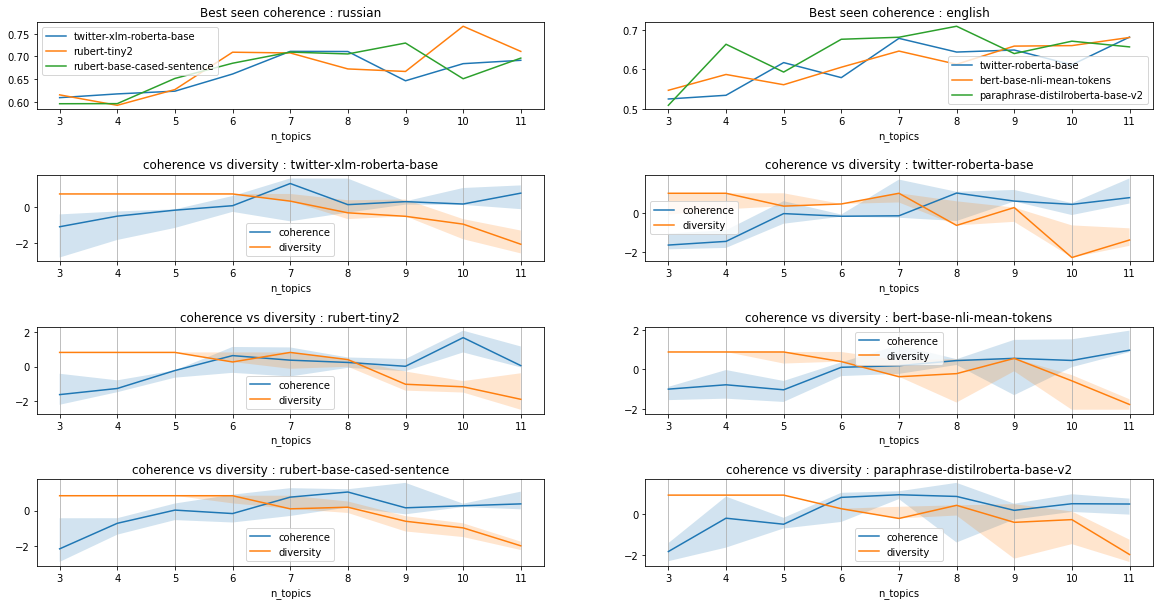

In [7]:
basepath='/B6_2k/10/'
resultpath = 'bench/results'+basepath
langs=['russian', 'english']
tocompare=[['twitter-xlm-roberta-base','rubert-tiny2', 'rubert-base-cased-sentence'], ['twitter-roberta-base', 'bert-base-nli-mean-tokens', "paraphrase-distilroberta-base-v2"]]
fig, axs = plt.subplots(len(tocompare[0])+1, len(tocompare), figsize=(20,10))
for u, (lang, models) in enumerate(zip(langs, tocompare)):
    dfs = [pd.read_csv(resultpath + lang+'_'+c + '/results.csv', index_col=0).set_index('n_topics') for c in tocompare[u]]
    axs[0, u].set_title('Best seen coherence : '+lang)
    for i, df in enumerate(dfs) :
        norm_df = ((df-df.mean())/df.std())
        norm_df.groupby(norm_df.index).median().plot(ax=axs[i+1, u]);
        for metric in norm_df.columns :
            ymin=norm_df.groupby(norm_df.index)[metric].min()
            ymax=norm_df.groupby(norm_df.index)[metric].max()
            axs[i+1, u].fill_between(norm_df.index.drop_duplicates(), ymin, ymax, alpha=0.2)
        ya=df.groupby(df.index)['coherence'].max()
        # ya=df.groupby(df.index)['coherence'].median()
        ymin=df.groupby(df.index)['coherence'].min()
        ymax=df.groupby(df.index)['coherence'].max()
        ya.plot(ax=axs[0, u])
        # axs[0, u].fill_between(df.index.drop_duplicates(), ymin, ymax, alpha=0.2)

        axs[i+1, u].xaxis.grid(True)
        minor_ticks=(df.index.drop_duplicates().values)
        # minor_ticks=np.arange(min(df.index.values), max(df.index.values))
        axs[i+1, u].set_xticks(minor_ticks, minor=True);
        axs[i+1, u].xaxis.grid(which='minor', alpha=0.2)
        axs[i+1, u].set_title('coherence vs diversity : ' + tocompare[u][i])
        
    axs[0, u].legend(labels=tocompare[u]);
    axs[0, u].set_xticks(minor_ticks, minor=True);
    axs[0, u].xaxis.grid(which='minor', alpha=0.2)
    fig.subplots_adjust(hspace=0.75)

# Visualize topics

In [10]:
# Other NLP
import pyLDAvis as pdvs
import gensim.corpora as corpora
import pickle
# Reset this variable to display day-by-day
basepath='/B6_2k/'
resultpath = 'bench/results'+basepath
topics={}
totranslate=[]
for u,lang in enumerate(langs) :
    flag=0
    topics[lang]={}
    # for i,m in enumerate(tocompare[u]) :
    for i, m in zip([[1], [0]][u], [['rubert-tiny2'], ['twitter-roberta-base']][u]) :
        topics[lang][m]={}
        for d in [str(d) for d in range (9, 13)] :
                df = pd.read_csv(resultpath +d +'/'+ lang+'_'+m + '/results.csv', index_col=0).set_index('n_topics')
                norm_df = ((df-df.mean())/df.std())
                
                folder=resultpath+d +'/'
                # optimal_run=0
                # if lang=='russian' :
                #     optimal_iter=[10, 10, 11][i]
                # if lang=='english' :
                #     optimal_iter=[12, 7, 10][i]
                # optimal_iter=df['n_topics'].loc(df.['coherence'].idxmax())
                # 1er n_topics après que les courbes se croisent
                optimal_iter=norm_df[norm_df['coherence']>=norm_df['diversity']].iloc[0].name
                

                # with np.load("%s/models/%d_%s.npz" % (folder+lang+'_'+m, optimal_iter, 'm'+str(i))) as model :
                # If we did several runs
                optimal_run=df.loc[optimal_iter].reset_index()['coherence'].idxmax()
                with np.load("%s/models/%d_%d_%s.npz" % (folder+lang+'_'+m, optimal_iter, optimal_run, 'm'+str(i))) as model :
                    tops = model['topics']
                    topic_term=model['topic-word-matrix']
                    topic_doc=model['topic-document-matrix']
                    topics[lang][m][d]={}
                    topics[lang][m][d]['topics']=tops
                    topics[lang][m][d]['topic_term']=topic_term
                    topics[lang][m][d]['topic_doc']=topic_doc
                    # [print(i, *t) for i,t in enumerate(topics)]

                # FOR BOW MODELS
                # dataset = Dataset()
                # dataset.load_custom_dataset_from_folder("datasets/LDA_2k/9/%s" %(lang))
                # id2word = corpora.Dictionary(dataset.get_corpus())
                # doc_lengths=[len(tw) for tw in pd.read_csv("datasets/LDA_10k/aug08_31/%s/corpus.tsv" %(lang), sep='\t', header=None)[0].to_list()]
                # viz_data=pdvs.prepare(topic_term, np.transpose(topic_doc), doc_lengths, [id2word[i] for i in range(len(topic_term.T))] , id2word.cfs.values())
                # pdvs.save_html(viz_data, folder+m+'_'+lang+'_pyldavis.html')

#                 # FOR CTM MODEL WE HAVE TO GET THE SOFTMAX OF THE TOPIC_TERM MATRIX, THEN NORMALIZE IT
#                 # Prepare dataset and model for pyldavis
#                 from scipy.special import softmax
#                 from sklearn.preprocessing import normalize
#                 dataset = Dataset()
#                 dataset.load_custom_dataset_from_folder("datasets/CTM_2k/preprocessed/%s/%s" %(d, lang))
                
#                 # If we want to do something with the base bert
#                 # base_bert=resultpath+d+'/' + lang+'_'+m +'/base_bert/_train.pkl'
#                 # with open (base_bert, 'rb') as f:
#                 #     ctmdataset = pickle.load(f)
#                 id2word = corpora.Dictionary(dataset.get_corpus())
#                 vocab = dataset.get_vocabulary()
#                 lines=[]
#                 # if lang=='english' :
#                 #     with open("datasets/CTM_2k/preprocessed/%s/%s" %(d, lang)+'/vocab_old.txt', 'r') as f :
#                 #         for line in f :
#                 #             # if line.rstrip() in vocab :
#                 #             lines.append(line.rstrip())
#                 #     vocab=lines
#                 doc_lengths=[len(tw) for tw in dataset.get_corpus()]
#                 # viz_data=pdvs.prepare(normalize(softmax(topic_term, axis=1), axis=1, norm='l1'), np.transpose(topic_doc), doc_lengths, [id2word[i] for i in range(len(topic_term.T))] , id2word.cfs.values())
#                 # viz_data=pdvs.prepare(softmax(topic_term, axis=1), topic_doc.T, doc_lengths, [id2word[i] for i in range(len(topic_term.T))] , id2word.cfs.values())
#                 # viz_data=pdvs.prepare(softmax(topic_term, axis=1), topic_doc.T, doc_lengths, vocab , id2word.cfs.values()) # BEFORE RUNNING INTO AN ISSUE WITH 1-DAY CTM DATA
#                 term_freq=[]
#                 # for w in vocab :
#                 #     id_token=id2word.token2id[w]
#                 #     count=id2word.cfs[id_token]
#                 #     term_freq.append(count)
#                 from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#                 vocab2id = {w: i for i, w in enumerate(vocab)}
#                 vec = CountVectorizer()
#                 entire_dataset = [' '.join(i) for i in dataset.get_corpus()]
#                 vec.fit(entire_dataset)
#                 idx2token = {v: k for (k, v) in vec.vocabulary_.items()}
#                 x_train = vec.transform(entire_dataset)
#                 term_freq = x_train.toarray().sum(axis=0)
                

#                 # Sometimes gensim cfs (term_frequency) token count is inferior to dataset.get_vocabulary
#                 viz_data=pdvs.prepare(softmax(topic_term, axis=1), topic_doc.T, doc_lengths, vec.vocabulary_.keys(), term_freq)
#                 pdvs.save_html(viz_data, folder+m+'_'+d+'_pyldavis.html')
                print(lang.upper()+'__________'+m+'________________________________________________')
                print (f'{d} august, {optimal_iter} topics found')

                if lang== 'russian' :
                    [(print (*t, gtranslate(t))) for t in tops]
                else :
                    [print (*t) for t in tops]
                # [print (*t) for t in tops]
# [print(m, '\n___', gtranslate(t)) for t in [tops for tops in [topics['russian'][m]['topics'] for m in topics['russian']]]]

/opt/anaconda/2021.05/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RUSSIAN__________rubert-tiny2________________________________________________
9 august, 4 topics found
лукашенко выбор беларусь белоруссия тихановская belarus омон минск belorussia милиция
['Lukashenka', 'choice', 'Belarus', 'Belarus', 'Tikhanovskaya', 'belarus', 'riot police', 'Minsk', 'belorussia', 'militia']
омоновец корж группа ехать атака также пустить беларуского мужчина ветер
['omonovec', 'cake', 'Group', 'drive', 'attack', 'also', 'let', 'Belarusian', 'the male', 'wind']
сябрысила нереально беларуского единение выбараў таракан футбол забывать участие лукашеску
['syabrysila', 'unreal', 'Belarusian', 'unity', 'elections', 'cockroach', 'football', 'forget', 'participation', 'Lukashenko']
свой это страна народ белорус надеяться очень жывебеларусь просто происходить
['own', 'This', 'side', 'people', 'Belarusian', 'hope', 'very', 'live in Belarus', 'simply', 'take place']
RUSSIAN__________rubert-tiny2________________________________________________
10 august, 6 topics found
коктейль 

### TEST Section for getting Pyldavis to work with OCTIS-CTM

In [227]:
np.shape(topic_term)

(6, 1999)

39

In [223]:
idx2token[1027]

'like'

In [218]:
id2word[0]

'election'

In [228]:
lines=[]
with open("datasets/CTM_2k/unpreprocessed/%s/%s" %(d, lang)+'/vocabulary.txt', 'r') as f :
    for line in f :
        lines.append(line)

In [229]:
lines
lines=[line.rstrip() for line in lines]
lines[1026]

'decision'

In [245]:
list(idx2token.values()).index('police')

39

In [250]:
list(vec.vocabulary_.keys()).index('police')

39

In [246]:
lines.index('police')

29

In [247]:
list(id2word.values()).index('police')

42

In [248]:
np.argmax(topic_term[0])

1026

In [257]:
np.argmax(softmax(topic_term, axis=1)[1])

706

In [252]:
vocab.index('police')

1870

In [134]:
id2word[421]

'body'

In [113]:
w_to_id = {w: i for i, w in enumerate(vocab)}


ItemsView(<gensim.corpora.dictionary.Dictionary object at 0x7f6e7eb5d220>)

In [255]:
voc = set()
for d in dataset.get_corpus():
    for w in set(d):
        voc.add(w)
voc = list(voc)

In [256]:
voc.index('police')

1832

In [ ]:
# dataset = Dataset()
# dataset.load_custom_dataset_from_folder("datasets/CTM_2k/preprocessed/%s/%s" %(d, lang))

In [ ]:
{id2word[k]: v for k, v in id2word.cfs.items()}

In [ ]:
gensim_id2word=corpora.Dictionary(dataset.get_corpus())

In [ ]:
for token in dataset.get_vocabulary():
    if token not in [id2word[k]for k, v in id2word.cfs.items()] :
        print(token)

In [ ]:
def reconstruct_term_frequency_if_missing :
    # From pyldavis doc :
    # term_frequency : array-like, shape n_terms
    # The count of each particular term over the entire corpus. The ordering of these counts should correspond with vocab and topic_term_dists.
    id2word = corpora.Dictionary(dataset.get_corpus())
    id2word.cfs.values()


'bench/results/B6_2k/10/'

In [ ]:
dataset.get_corpus()[0]

In [ ]:
gensim_id2word.token2id

ORIGINAL RESULT IMPORT

In [ ]:
# Other NLP
import pyLDAvis as pdvs
import gensim.corpora as corpora
topics={}
totranslate=[]
for u,lang in enumerate(langs) :
    print(lang+'__________________________________________________________')
    topics[lang]={}
    for i,m in enumerate(tocompare[u]) :
            df = pd.read_csv(resultpath + lang+'_'+m + '/results.csv', index_col=0).set_index('n_topics')
            folder=resultpath
            optimal_run=0
            if lang=='russian' :
                optimal_iter=[10, 10, 11][i]
            if lang=='english' :
                optimal_iter=[12, 7, 10][i]
            
            # with np.load("%s/models/%d_%s.npz" % (folder+lang+'_'+m, optimal_iter, 'm'+str(i))) as model :
            # If we did several runs
            optimal_run=df.loc[optimal_iter].reset_index()['coherence'].idxmax()
            with np.load("%s/models/%d_%d_%s.npz" % (folder+lang+'_'+m, optimal_iter, optimal_run, 'm'+str(i))) as model :
                tops = model['topics']
                topic_term=model['topic-word-matrix']
                topic_doc=model['topic-document-matrix']
                topics[lang][m]={}
                topics[lang][m]['topics']=tops
                topics[lang][m]['topic_term']=topic_term
                topics[lang][m]['topic_doc']=topic_doc
                # [print(i, *t) for i,t in enumerate(topics)]

            # FOR BOW MODELS
            # dataset = Dataset()
            # dataset.load_custom_dataset_from_folder("datasets/LDA_2k/9/%s" %(lang))
            # id2word = corpora.Dictionary(dataset.get_corpus())
            # doc_lengths=[len(tw) for tw in pd.read_csv("datasets/LDA_10k/aug08_31/%s/corpus.tsv" %(lang), sep='\t', header=None)[0].to_list()]
            # viz_data=pdvs.prepare(topic_term, np.transpose(topic_doc), doc_lengths, [id2word[i] for i in range(len(topic_term.T))] , id2word.cfs.values())
            # pdvs.save_html(viz_data, folder+m+'_'+lang+'_pyldavis.html')

            # FOR CTM MODEL WE HAVE TO GET THE SOFTMAX OF THE TOPIC_TERM MATRIX, THEN NORMALIZE IT
            # Prepare dataset and model for pyldavis
            from scipy.special import softmax
            from sklearn.preprocessing import normalize
            dataset = Dataset()
            dataset.load_custom_dataset_from_folder("datasets/CTM_2k/preprocessed/aug08_31/%s" %(lang))
            id2word = corpora.Dictionary(dataset.get_corpus())
            doc_lengths=[len(tw) for tw in pd.read_csv("datasets/CTM_2k/preprocessed/aug08_31/%s/corpus.tsv" %(lang), sep='\t', header=None)[0].to_list()]
            # viz_data=pdvs.prepare(normalize(softmax(topic_term, axis=1), axis=1, norm='l1'), np.transpose(topic_doc), doc_lengths, [id2word[i] for i in range(len(topic_term.T))] , id2word.cfs.values())
            viz_data=pdvs.prepare(softmax(topic_term, axis=1), np.transpose(topic_doc), doc_lengths, [id2word[i] for i in range(len(topic_term.T))] , id2word.cfs.values())
            pdvs.save_html(viz_data, folder+m+'_pyldavis.html')
            print('__________'+m+'________________________________________________')
            
            # if lang== 'russian' :
                # [(print (*t), print(gtranslate(t))) for t in tops]
            # else :
            #     [print (*t) for t in tops]
            [print (*t) for t in tops]
print(gtranslate(t)) for t in [tops for tops in topics['russian'][m] for m in topics['russian']]

### DYNAMIC TOPICS

In [ ]:
en=pd.read_csv('bench/orig_datasets/CTM_2k/aug08_31_english.csv', lineterminator='\n')
ru=pd.read_csv('bench/orig_datasets/CTM_2k/aug08_31_russian.csv', lineterminator='\n')
df=pd.read_csv('bench/orig_datasets/CTM_2k/aug08_31_' + lang + '.csv', lineterminator='\n')

In [16]:
lang='russian'
m = 'rubert-tiny2'

In [ ]:
import random
n = random.randrange(len(df[~df.deleted]))
import numpy as np
# Print top N topics for this tweet
topic_numbers = np.sort(topics[lang][m]["topic_doc"].T[n])[::-1][:3]
# topic_number = np.argmax(topics[lang][m]["topic_doc"].T[n]) # récupère l'index du topic correspondant à un msg pris au hasard
print("tweet n° ", "https://twitter.com/twitter/status/"+str(df[~df.deleted]['status_id'].loc[n]), "\n_____\n", "doc d'origine : ", # voir un doc au hasard
df[~df.deleted]['text'].loc[n], "\n_____\n", "doc pré-traité : ", df[~df.deleted]['preproc'].loc[n]) # doc d'origine"
for top, prct in zip(np.argsort(topics[lang][m]["topic_doc"].T[n])[::-1], topic_numbers):
    print  ("\n_____\ntopic n° %d : " %(top)+' {:.2%}'.format(prct))
    print(topics[lang][m]['topics'][top])

In [ ]:
def pickrnd(items) :
    n = random.randrange(len(items))
    return items[n]

Without retweets

In [ ]:
# Checking both langs ?
df=pd.concat([en, ru], axis=0)

In [ ]:
data=pd.read_csv('datasets/beltweets_nlp.csv')

In [ ]:
df=df.join(data[data.lang==lang[:2]][['created_at', 'status_id']].set_index('status_id'), on='status_id')
df['created_at']=pd.to_datetime(df['created_at'])
df.loc[~df.deleted, 'best_topic']=np.argmax(topics[lang][m]["topic_doc"].T, axis=1).astype(int)
df['best_topic']=df['best_topic'].astype('Int64')

Import larger dataset including retweets

In [ ]:
data=pd.read_csv('datasets/beltweets_nlp_RT.csv')
data['created_at']=pd.to_datetime(data['created_at'])
data['status_id']=data['status_id'].astype(str).replace('nan', np.nan)
data['retweet_status_id']=data['retweet_status_id'].astype('Int64').astype(str).replace('<NA>', np.nan)
data['orig_tweet_id']=data[['retweet_status_id', 'status_id']].apply(lambda x: x['retweet_status_id'] if pd.notnull(x['retweet_status_id']) else x['status_id'], axis=1)

Sum of topic mixture

In [ ]:
toplot = zip(langs, ['rubert-tiny2', "twitter-roberta-base"])
freq='24H'
epicepoch=pd.dataframe()
for lang, m in toplot :
    df=pd.read_csv('bench/orig_datasets/CTM_2k/aug08_31_' + lang + '.csv', lineterminator='\n')
    df.loc[~df.deleted, 'best_topic']=np.argmax(topics[lang][m]["topic_doc"].T, axis=1).astype(int)
    df['best_topic']=df['best_topic'].astype('Int64')
    # Join best topics and topic distrib to the lang DF
    df['status_id']=df['status_id'].astype(str).replace('<NA>', np.nan)
    # Sum topic distribution over tweets (1 tweet = several topics)
    topic_distrib=pd.DataFrame((topics[lang][m]["topic_doc"].T), columns=[n for n in range(len(topics[lang][m]["topic_doc"]))], index=df.loc[~df.deleted, 'status_id'])
    df=data[data.lang==lang[:2]].join(df.set_index('status_id')[['best_topic', 'deleted']], on='orig_tweet_id')
    df=df.join(topic_distrib, on='orig_tweet_id')

    for n in range(len(topics[lang][m]["topics"])) :
    # g=en[(en['created_at'].dt.date<=pd.Timestamp(2020,8,18))& (en["best_topic"]==n)].groupby(\
        g=df[['created_at', 'best_topic', 'retweet_count']+list(range(len(topics[lang][m]["topic_doc"])))][(df['created_at'].dt.date>=pd.Timestamp(2020,8,8)) & (df['created_at'].dt.date<=pd.Timestamp(2020,8,31))].groupby(\
        pd.Grouper(key='created_at', freq=freq, convention='start'))[n].sum()
        p=g.plot(figsize=(24,13))
        y=g.max()
        x=g.idxmax()
        # plt.text(x,y, s=linebreak(bel_top_retweets['text'].iloc[0]), color=p.lines[-1].get_color())
        plt.annotate(text=' '.join(topics[lang][m]["topics"][n]), xy=(x,y), fontsize=12, color=p.lines[-1].get_color())   #Try add   #, wrap=True)
plt.title("Mix of topics in the tweets (including RT) per "+freq);
plt.ylabel('Topic number');
plt.ylabel('Number of tweets / 3 hour period');

AttributeError: module 'pandas' has no attribute 'dataframe'

In [ ]:
topic_distrib=pd.DataFrame((topics["tfidf"]["topic_doc"].T), columns=[n for n in range(len(topics["tfidf"]["topic_doc"]))], index=en.loc[~en.deleted, 'status_id'])

In [ ]:
data=data.join(en.set_index('status_id')['best_topic'], on='orig_tweet_id')

In [ ]:
data=data.join(topic_distrib, on='orig_tweet_id')

In [ ]:
tp = zip(langs, ['rubert-base-cased-sentence', "twitter-roberta-base"])
freq='24H'
for lang, m in tp :
    toplot=data[range(len(topics[lang][m]["topic_doc"]))].sum().sort_values()
    toplot.index = pd.Series(toplot.index).apply(lambda x: 'Topic %s : '%str(x)+str(topics[lang][m]['topics'][x]))
    toplot.plot.barh(figsize=(8,15));
    plt.title("Distribution for the topic mix, RT included");

In [ ]:
toplot=data['best_topic'].value_counts().sort_values(ascending=True)
toplot.index = pd.Series(toplot.index).apply(lambda x: 'Topic %s : '%str(x)+str(topics["tfidf"]['topics'][x]))
toplot.plot.barh(figsize=(8,15));
toplot=data[data['retweet_status_id'].isna()]['best_topic'].value_counts().sort_values(ascending=True)
toplot.index = pd.Series(toplot.index).apply(lambda x: 'Topic %s : '%str(x)+str(topics["tfidf"]['topics'][x]))
toplot.plot.barh(figsize=(8,15));
plt.title("Distribution for the tweet's top topic, RT included");

Sorted by weight of the topic over the corpus

In [ ]:
def decoupe(lst, n) :
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [ ]:
import matplotlib.pyplot as plt
slices = decoupe(data[range(len(topics["tfidf"]["topic_doc"]))].sum().sort_values(ascending=False).index.values, 5)
fig, axs = plt.subplots(nrows=len(slices), ncols=1, figsize=(14,21))
for i, slice in enumerate(slices) :
    ax=plt.subplot(6, 1, i+1)
    for n in slice :
        # g=en[(en['created_at'].dt.date<=pd.Timestamp(2020,8,18))& (en["best_topic"]==n)].groupby(\
        g=data[['created_at', 'best_topic']+list(range(len(topics["tfidf"]["topic_doc"])))][(data['created_at'].dt.date>=pd.Timestamp(2020,8,9)) & (data['created_at'].dt.date<=pd.Timestamp(2020,8,31))].groupby(\
        pd.Grouper(key='created_at', freq='3H', convention='start'))[n].sum()
        p=g.plot(ax=ax)
        y=g.max()
        x=g.idxmax()
        # plt.text(x,y, s=linebreak(bel_top_retweets['text'].iloc[0]), color=p.lines[-1].get_color())
        ax.annotate(text=' '.join(topics["tfidf"]["topics"][n]), xy=(x,y), fontsize=12, color=p.lines[-1].get_color())
plt.title("Topic distribution over time (tweet rate)");
plt.ylabel('Topic number');
plt.ylabel('Number of tweets / 3 hour period');

STACKED

In [ ]:
# STACKED
from scipy.special import softmax
g=data[['created_at']+list(range(len(topics["tfidf"]["topic_doc"])))][(data['created_at'].dt.date>=pd.Timestamp(2020,8,9)) & (data['created_at'].dt.date<=pd.Timestamp(2020,8,31))].groupby(\
    pd.Grouper(key='created_at', freq='2D', convention='start'))
plt.figure(figsize=(15,12))
plt.stackplot(g.sum().index, g.sum().to_numpy().T, labels=list(range(len(topics["tfidf"]["topic_doc"]))));


In [ ]:
import matplotlib.pyplot as plt
for n in range(len(topics["tfidf"]["topics"])) :
    # g=en[(en['created_at'].dt.date<=pd.Timestamp(2020,8,18))& (en["best_topic"]==n)].groupby(\
    g=data[['created_at', 'best_topic']][(data['created_at'].dt.date>=pd.Timestamp(2020,8,10)) & (data['created_at'].dt.date<=pd.Timestamp(2020,8,31))& (data["best_topic"]==n)].groupby(\
    pd.Grouper(key='created_at', freq='3H', convention='start')).size()
    p=g.plot(figsize=(24,13))
    y=g.max()
    x=g.idxmax()
    # plt.text(x,y, s=linebreak(bel_top_retweets['text'].iloc[0]), color=p.lines[-1].get_color())
    plt.annotate(text=' '.join(topics["tfidf"]["topics"][n]), xy=(x,y), fontsize=12, color=p.lines[-1].get_color())   #Try add   #, wrap=True)
plt.title("Tweet rate per topic (1 tweet = 1 topic)");
plt.ylabel('Topic number');
plt.ylabel('Number of tweets / 3 hour period');